In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table

# astropy to import fits files
from astropy.io import fits

In [2]:
file_data = fits.open("../CFHT/812176i.fits")

string_data = file_data[0].header["date"] # gets the data from the fits file
string_data

'2012-05-09T14:37:08'

In [3]:
from astropy.time import Time
def date_string_to_tuple(date_string):
    date = date_string.split('T')[0]
    time = date_string.split('T')[1]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    day = int(date.split('-')[2])
    hour = int(time.split(':')[0])
    minute = int(time.split(':')[1])
    second = int(float(time.split(':')[2]))
    # Convert to BJD using astropy Time
    # Convert to BJD_TDB
    time_tuple = (year, month, day, hour, minute, second)
    return time_tuple

time_tuple = date_string_to_tuple(file_data[0].header["date"])
time_tuple  # prints the time tuple

(2012, 5, 9, 14, 37, 8)

(640.0, 670.0)

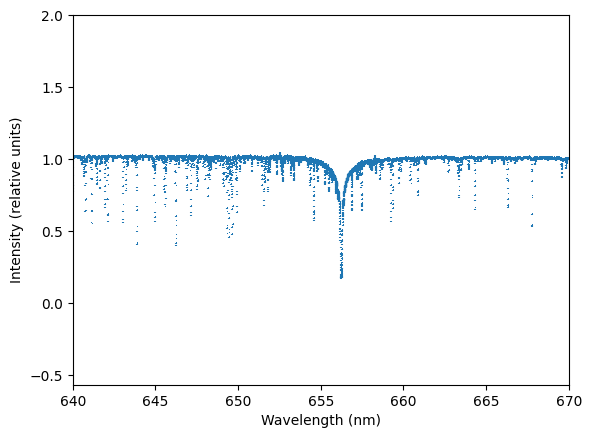

In [4]:
# df = pd.DataFrame(data[0].data[0:2])
col_1 = file_data[0].data[0]
col_2 = file_data[0].data[1]
col_3 = file_data[0].data[2]
df = pd.DataFrame({'Wavelength': col_1, 'Intensity': col_2, 'Error': col_3})
df.head()
# ensure data is sorted by wavelength
# plt.plot(df['Wavelength'], df['Intensity'], ',')
plt.errorbar(df['Wavelength'], df['Intensity'], yerr=df['Error'], fmt=',')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')
plt.xlim(640, 670)


In [5]:
wavelengths = np.array(df['Wavelength'])
intensities = np.array(df['Intensity'])
errors = np.array(df['Error'])
# new_df = pd.DataFrame({'Wavelength': wavelengths, 'Intensity': intensities, 'Error': errors})
# new_df
new_df = pd.DataFrame({'Wavelength': wavelengths, 'Intensity': intensities, 'Error': errors})

In [6]:
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

# plt.style.use("dark_background")

from astropy.modeling.models import Linear1D
from astropy import constants
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f2beba32f90>

In [7]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Lorentz1D, Linear1D, Voigt1D, Moffat1D
from astropy.modeling.fitting import LevMarLSQFitter, LMLSQFitter, SLSQPLSQFitter

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12340224887594725
            Iterations: 18
            Function evaluations: 204
            Gradient evaluations: 18


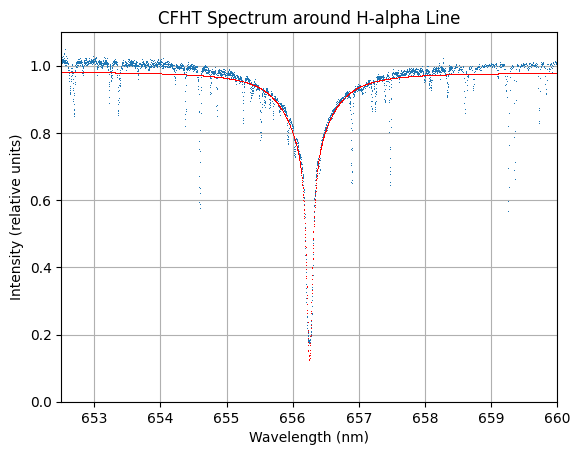

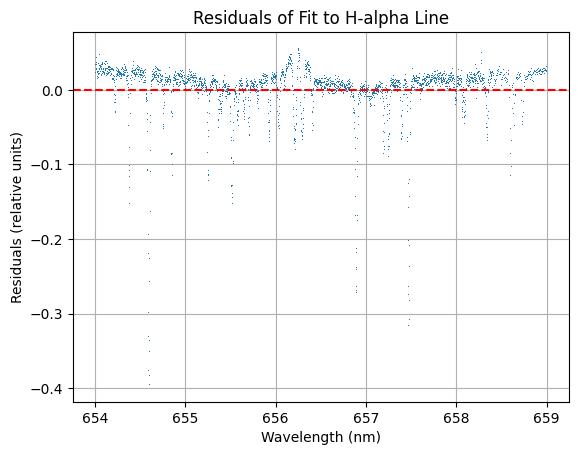

In [8]:
wls = df['Wavelength'].values * u.nm
spec = df['Intensity'].values
noise_estimate = np.std(spec)

selection = (wls > 654. *u.nm) & (wls < 659 *u.nm)


guesses_voigt = [6562.8*u.AA, -1, 8*u.AA, 2*u.AA] # stats
fitter = SLSQPLSQFitter()
model = Voigt1D(*guesses_voigt) + Linear1D(intercept=1, slope=0) + Lorentz1D(amplitude=-3, x_0=6562.8*u.AA, fwhm=2*u.AA)
fitted_voigt = fitter(model, wls[selection], spec[selection],
                         weights=noise_estimate)

# absorption_model_guess = Linear1D(slope=0, intercept=1) + Lorentz1D(
#     amplitude=-0.8, x_0=656, fwhm=1
# )
plt.plot(df['Wavelength'], df['Intensity'], ',')
plt.plot(
    wls,
    fitted_voigt(wls),
    ',',
    color='red'
)
plt.ylabel('Intensity (relative units)')
plt.xlabel('Wavelength (nm)')
plt.xlim(652.5, 660)
plt.ylim(0,1.1)
plt.title('CFHT Spectrum around H-alpha Line')
plt.grid()
plt.show()

residuals = spec[selection] - fitted_voigt(wls[selection])
plt.plot(wls[selection], residuals, ',')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Residuals (relative units)')
plt.xlabel('Wavelength (nm)')
plt.title('Residuals of Fit to H-alpha Line')
plt.grid()
plt.show()

In [9]:
absorption  = fitted_voigt[0] + fitted_voigt[2]
continuum = fitted_voigt[1]

(0.0, 1.5)

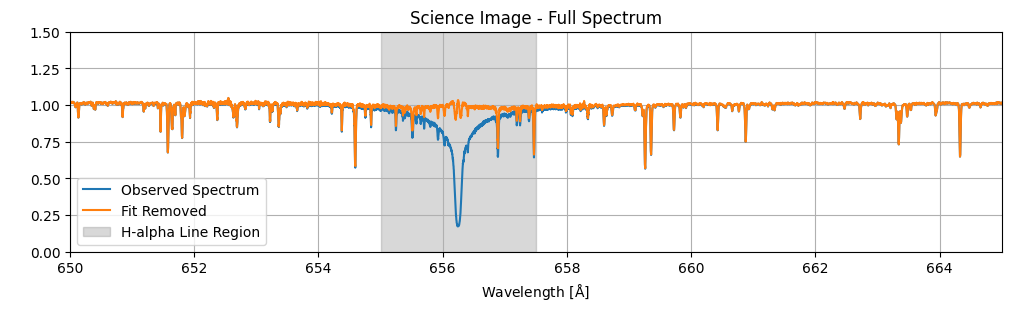

In [10]:
fig, ax1 = plt.subplots(1, 1, layout='constrained')
fig.set_size_inches(10,3)
# sort data by wavelength
srt = np.argsort(wls)
wls = wls[srt]
spec = spec[srt]
ax1.plot(wls, spec, label='Observed Spectrum')
ax1.plot(wls, spec-absorption(wls), label='Fit Removed')
ax1.grid()
#shade alpha line region
ax1.axvspan(655*u.nm, 657.5*u.nm, color='grey', alpha=0.3, label='H-alpha Line Region')
ax1.legend()
ax1.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax1.set_title("Science Image - Full Spectrum")
ax1.set_xlim(650, 665)
ax1.set_ylim(0,1.5)

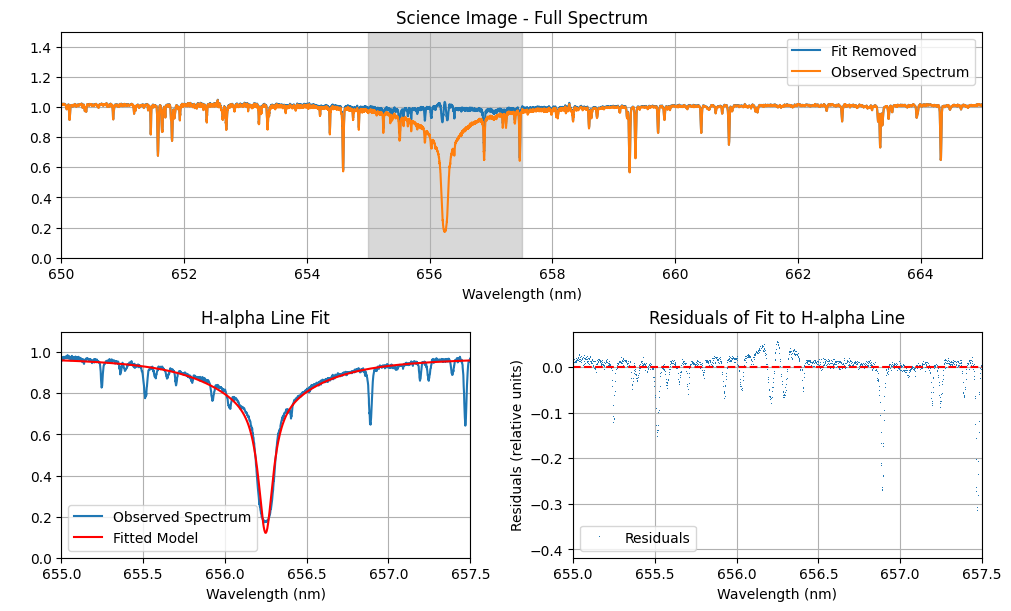

In [11]:
# create a last 3 plots into one figure
# top across whole, science image spectra with fit removed
# bottom left, zoom in on h-alpha with fit
# bottom right, residuals

fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10,6)

# use a 2x2 GridSpec so the top plot can span both columns and the bottom row
# can have left (fit) and right (residuals) panels
gs = fig.add_gridspec(2, 2)

# sort data by wavelength (don't overwrite original names to avoid side effects)
srt = np.argsort(wls)
wls_sorted = wls[srt]
spec_sorted = spec[srt]
selection_sorted = (wls_sorted > 654. *u.nm) & (wls_sorted < 659 *u.nm)

# top plot spanning both columns
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(wls_sorted, spec_sorted - absorption(wls_sorted), label='Fit Removed')
ax1.plot(wls_sorted, spec_sorted, label='Observed Spectrum')
#shade region of H-alpha line
ax1.axvspan(655, 657.5, color='grey', alpha=0.3)

ax1.set_xlabel("Wavelength (nm)")
ax1.set_title("Science Image - Full Spectrum")
ax1.grid(True)
ax1.legend()
ax1.set_xlim(650, 665)
ax1.set_ylim(0, 1.5)

# bottom-left: show original and fitted Voigt model around H-alpha
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title("H-alpha Line Fit")
ax2.plot(wls_sorted, spec_sorted, label='Observed Spectrum')
ax2.plot(
    wls_sorted,
    fitted_voigt(wls_sorted),
    label='Fitted Model',
    color='red'
)
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_xlim(655, 657.5)
ax2.set_ylim(0, 1.1)

# bottom-right: residuals of the fitted Voigt model
ax3 = fig.add_subplot(gs[1, 1])
residuals = spec[selection_sorted] - fitted_voigt(wls[selection_sorted])
ax3.plot(wls[selection_sorted], residuals, ',', label='Residuals')
ax3.axhline(0, color='red', linestyle='--')
ax3.legend()
ax3.set_ylabel('Residuals (relative units)')
ax3.set_xlabel('Wavelength (nm)')
ax3.set_title('Residuals of Fit to H-alpha Line')
ax3.set_xlim(655, 657.5)
ax3.grid(True)

plt.show()

/home/groneck/miniforge3/lib/python3.12/site-packages/scipy-1.15.2-py3.12-linux-x86_64.egg/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6619.128922106067
            Iterations: 33
            Function evaluations: 242
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6619.098301285808
            Iterations: 24
            Function evaluations: 187
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5660.661417041712
            Iterations: 92
            Function evaluations: 732
            Gradient evaluations: 92


/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/modeling/functional_models.py:3212: RuntimeWarning: overflow encountered in power
  return amplitude * (1 + ((x - x_0) / gamma) ** 2) ** (-alpha)
/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/modeling/functional_models.py:3212: RuntimeWarning: overflow encountered in multiply
  return amplitude * (1 + ((x - x_0) / gamma) ** 2) ** (-alpha)
/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/modeling/statistic.py:62: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(weights * np.subtract(model_vals, measured_vals)))
/home/groneck/miniforge3/lib/python3.12/site-packages/numpy-2.2.3-py3.12-linux-x86_64.egg/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5697.395172431959
            Iterations: 71
            Function evaluations: 566
            Gradient evaluations: 71


Text(0, 0.5, 'Intensity (relative units)')

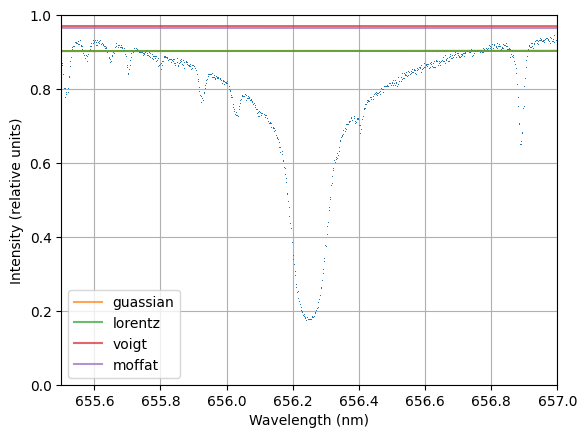

In [12]:
fitted_absorption_guess_guassian = Linear1D(slope=0, intercept=1) + Gaussian1D(
    amplitude=-0.8, mean=656, stddev=1
)

absorption_model_guess_lorentz = Linear1D(slope=0, intercept=1) + Lorentz1D(
    amplitude=-0.8, x_0=656, fwhm=1
)

absorption_model_guess_voigt = Linear1D(slope=0, intercept=1) + Voigt1D(
    amplitude_L=-0.8, x_0=656, fwhm_L=1, fwhm_G=1
)

absorption_model_guess_moffat = Linear1D(slope=0, intercept=1) + Moffat1D(
    amplitude=-0.8, x_0=656, gamma=1, alpha=1
)

models = [
    ('guassian', fitted_absorption_guess_guassian),
    ('lorentz', absorption_model_guess_lorentz),
    ('voigt', absorption_model_guess_voigt),
    ('moffat', absorption_model_guess_moffat)
]


fitter = SLSQPLSQFitter()
def fit_model(model, wavelengths, intensities):
    fitted_model = fitter(model, wavelengths, intensities)
    return fitted_model

plt.plot(wavelengths, intensities, ',')

for model_set in models:
    name, model = model_set
    fitted_absorption_model = fit_model(model, wavelengths, intensities)
    # sort wavelengths for plotting
    sorted_indices = np.argsort(wavelengths)
    plt.plot(wavelengths[sorted_indices], fitted_absorption_model(wavelengths[sorted_indices]), '-', label=name, alpha=0.7)


plt.xlim(655.5, 657)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6619.128922106067
            Iterations: 33
            Function evaluations: 242
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6619.098301285808
            Iterations: 24
            Function evaluations: 187
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5660.661417041712
            Iterations: 92
            Function evaluations: 732
            Gradient evaluations: 92
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5697.395172431959
            Iterations: 71
            Function evaluations: 566
            Gradient evaluations: 71


Text(0, 0.5, 'Intensity (relative units)')

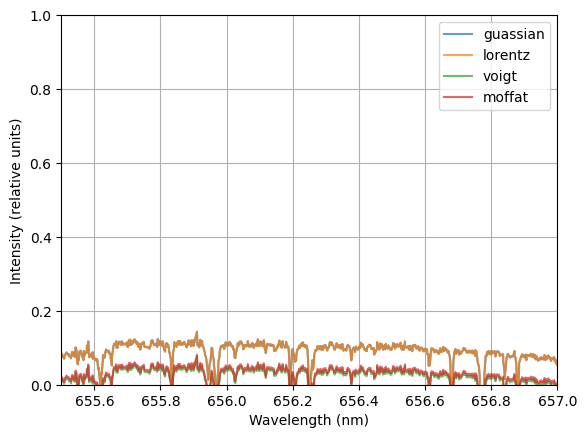

In [13]:
for model_set in models:
    name, model = model_set
    fitted_absorption_model = fit_model(model, wavelengths, intensities)
    # sort wavelengths for plotting
    sorted_indices = np.argsort(wavelengths)
    plt.plot(wavelengths[sorted_indices], intensities-fitted_absorption_model(wavelengths[sorted_indices]), '-', label=name, alpha=0.7)


plt.xlim(655.5, 657)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 930758127108801.1
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3


(654.2, 658.2)

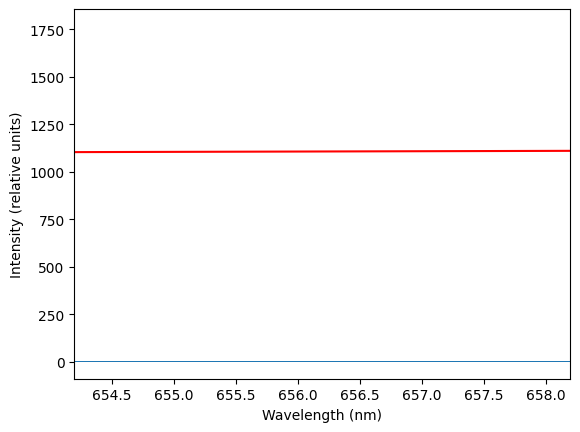

In [14]:
lmfitter = SLSQPLSQFitter()
selection = (wavelengths > 640) & (wavelengths < 670)
fitted_absorption_model = lmfitter(
    model=absorption_model_guess_voigt, x=wavelengths[selection], y=intensities[selection], weights=1 / errors[selection]
)

plt.plot(wavelengths, intensities, ',')
# sort wavelengths for plotting
sorted_indices = np.argsort(wavelengths)
plt.plot(wavelengths[sorted_indices], fitted_absorption_model(wavelengths[sorted_indices]), color='red')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')
plt.xlim(654.2, 658.2)


(640.0, 670.0)

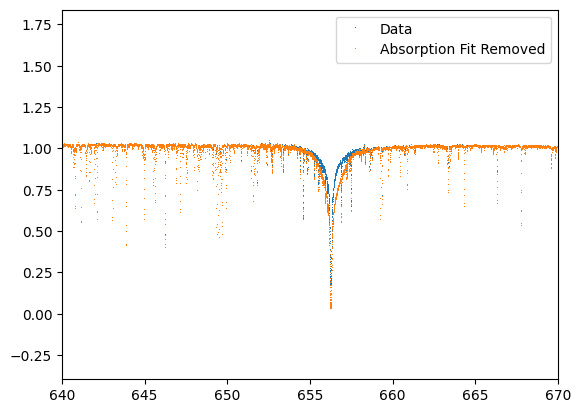

In [15]:
continuum_fit, absorption_fit = fitted_absorption_model

plt.plot(wavelengths, df['Intensity'], ',', label='Data')
plt.plot(wavelengths, df['Intensity'] - absorption_fit(wavelengths), ',', label='Absorption Fit Removed')
plt.legend()
plt.xlim(640, 670)


In [16]:
#documentation example:
# EQW = (
#     -absorption_fit(wavelengths.value[selection]).sum() / continuum_fit.intercept * u.nm
# )
# EQW

EQW = (
    -absorption_fit(wavelengths[selection]).sum() / continuum_fit.intercept
)
EQW

np.float64(-116.12855693381711)

In [17]:
np.random.seed(42)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import Linear1D, Gaussian1D
from astropy.io import fits
import os

def calculate_eqw(data, plot=False, line_center=656.28*u.nm, window=(640*u.nm, 670*u.nm)):
    wavelengths = np.asarray(data['Wavelength'], dtype=float) * u.nm
    intensities = np.asarray(data['Intensity'], dtype=float)
    errors      = np.asarray(data['Error'], dtype=float)

    # 1) Filter non-finites up front
    finite = np.isfinite(wavelengths.value) & np.isfinite(intensities) & np.isfinite(errors)
    wavelengths, intensities, errors = wavelengths[finite], intensities[finite], errors[finite]

    # 2) Focus on a wavelength window around the line
    sel = (wavelengths > window[0]) & (wavelengths < window[1])
    if not np.any(sel):
        return np.nan  # nothing to fit

    w, f = wavelengths[sel], intensities[sel]

    # 3) Build a reasonable initial model guess
    #    Estimate continuum ~ median of edges in the window
    left  = (w > window[0]) & (w < line_center - 5*u.nm)
    right = (w > line_center + 5*u.nm) & (w < window[1])
    if np.any(left) and np.any(right):
        cont_level = 0.5 * (np.median(f[left]) + np.median(f[right]))
    else:
        cont_level = np.median(f)

    # Rough line depth guess: difference between continuum and min in core
    core = np.abs(w - line_center) < 1.0*u.nm
    depth_guess = cont_level - np.min(f[core]) if np.any(core) else 0.1 * cont_level
    amp_guess = -abs(depth_guess) # absorption → negative amplitude

    # Rough width guess (in same units as w)
    std_guess = 0.8*u.nm

    #absorption_model_guess = Linear1D(slope=0.0, intercept=cont_level) + Gaussian1D(
    #    amplitude=amp_guess, mean=line_center, stddev=std_guess
    #)
    absorption_model_guess = Voigt1D(amplitude_L=amp_guess, x_0=line_center, fwhm_G=std_guess, fwhm_L=4*u.nm) + Linear1D(intercept=1, slope=0) + Lorentz1D(amplitude=amp_guess*2, x_0=line_center, fwhm=4*u.nm)

    # 4) Fit
    fitter = SLSQPLSQFitter()
    fitted_absorption_model = fitter(
        model=absorption_model_guess,
        x=w, y=f, weights = 1/std_guess
        )

    absorption_fit  = fitted_absorption_model[0] + fitted_absorption_model[2]
    continuum_fit = fitted_absorption_model[1]
    # Extract submodels
    # For a sum model m = m0 + m1, you can index by order:
    #continuum_fit, absorption_fit = fitted_absorption_model

    if plot:
        plt.figure()
        plt.plot(w, f, ',', label='Data')
        plt.plot(w, fitted_absorption_model(w.value), '-', label='Fit')
        plt.plot(w, f - absorption_fit(w.value), ',', label='Absorption Fit Removed')
        plt.legend()
        plt.xlim(*window)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity')
        plt.tight_layout()
    print(absorption_fit(w).sum())
    #eqw_value = (-absorption_fit(w).sum() / continuum_fit.intercept * u.nm)
    #EQW

    Fc = continuum_fit(w)
    F  = fitted_absorption_model(w)

    good = Fc > 0
    Fc = Fc[good]
    F  = F[good]
    wl = w.value[good]

    integrand = 1.0 - F / Fc
    eqw_value = np.trapezoid(integrand, wl) * u.nm
    return eqw_value

# --- Batch over files ---
base_file_path = "../CFHT/"
file_names = sorted(os.listdir(base_file_path))

eqw_rows = []
used_names = []
time_tuples = []

for file_name in file_names:
    if not file_name.endswith('.fits'):
        continue
    file_path = os.path.join(base_file_path, file_name)
    with fits.open(file_path) as hdul:
        col_1 = hdul[0].data[0]
        col_2 = hdul[0].data[1]
        col_3 = hdul[0].data[2]
    df = pd.DataFrame({'Wavelength': col_1, 'Intensity': col_2, 'Error': col_3})

    eqw_value = calculate_eqw(df, plot=False)


    time_tuple = date_string_to_tuple(hdul[0].header["date"])
    time_tuples.append(time_tuple)

    eqw_rows.append(eqw_value.value)
    used_names.append(file_name)

eqw_data_frame = pd.DataFrame({'data_set': used_names, 'EQW_Value': eqw_rows, 'Time(Y,M,D,H,M,S)': time_tuples})
print(eqw_data_frame)


/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/modeling/functional_models.py:1926: RuntimeWarning: overflow encountered in divide
  return self._wrap_wofz(z).real * self.sqrt_ln2pi / fwhm_G * fwhm_L * amplitude_L
/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/modeling/functional_models.py:1926: RuntimeWarning: overflow encountered in multiply
  return self._wrap_wofz(z).real * self.sqrt_ln2pi / fwhm_G * fwhm_L * amplitude_L
/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in square
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 33.96168619835
            Iterations: 51
            Function evaluations: 577
            Gradient evaluations: 51
-197.400775485393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 33.676151723119204
            Iterations: 58
            Function evaluations: 654
            Gradient evaluations: 58
-199.71903776247478
Optimization terminated successfully    (Exit mode 0)
            Current function value: 36.61254379192505
            Iterations: 62
            Function evaluations: 718
            Gradient evaluations: 62
-166.93858014785903


/home/groneck/miniforge3/lib/python3.12/site-packages/scipy-1.15.2-py3.12-linux-x86_64.egg/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in reduce
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in add
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 31
            Function evaluations: 403
            Gradient evaluations: 31
nan
Iteration limit reached    (Exit mode 9)
            Current function value: 33.886379970953755
            Iterations: 100
            Function evaluations: 1074
            Gradient evaluations: 100
-201.6004659100287
Optimization terminated successfully    (Exit mode 0)
            Current function value: 39.788265600899486
            Iterations: 59
            Function evaluations: 703
            Gradient evaluations: 59
-166.94758207707264
Iteration limit reached    (Exit mode 9)
            Current function value: 35.509732095014655
            Iterations: 100
            Function evaluations: 1066
            Gradient evaluations: 100
-204.55344004165684
Optimization terminated successfully    (Exit mode 0)
            Current function value: 39.04878423013219
            Iteration

/home/groneck/miniforge3/lib/python3.12/site-packages/astropy-7.0.1-py3.12-linux-x86_64.egg/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 233.63647674638136
            Iterations: 49
            Function evaluations: 640
            Gradient evaluations: 49
-384.0440869964042
Optimization terminated successfully    (Exit mode 0)
            Current function value: 41.7105558642356
            Iterations: 76
            Function evaluations: 886
            Gradient evaluations: 76
-169.0871330959607
Iteration limit reached    (Exit mode 9)
            Current function value: 38.93606305592808
            Iterations: 100
            Function evaluations: 1066
            Gradient evaluations: 100
-201.47092198990188
Optimization terminated successfully    (Exit mode 0)
            Current function value: 41.35324713157786
            Iterations: 59
            Function evaluations: 667
            Gradient evaluations: 59
-169.1135929521292
Iteration limit reached    (Exit mode 9)
            Current function value: 38.8360367586051

In [20]:
# save to csv
eqw_data_frame.to_csv('cfht_eqw_results.csv', index=False)

In [19]:

from astropy.table import QTable
saved = QTable.read('cfht_eqw_results.csv')
tester = saved['EQW_Value'].value.tolist()

fin = []
for object in tester:
    try:
        fin += [float((object.strip('nm').strip('an')))]
    except:
        fin += '!'
array = np.asarray(fin)
indices_to_delete = np.where(array == "!")
new_arr = np.delete(array, indices_to_delete)
lister = new_arr.tolist()
just_ran = [float(val) for val in lister]
just_ran

eqs = eqw_data_frame['EQW_Value'].dropna().tolist()
eqs[1]

FileNotFoundError: [Errno 2] No such file or directory: 'cfht_eqw_results.csv'

[0.7575837288612793,
 0.7544463772296315,
 0.6523710109367866,
 0.7682307080664449,
 0.6575252497778122,
 0.7802159853058337,
 0.6637660264696411,
 0.7749286504061754,
 0.7904278101450447,
 0.6837876488662668,
 1.3199787845573552,
 0.6416499093964437,
 0.7533403174495348,
 0.6206603752947282,
 0.7434770611238948,
 0.7490404602492816,
 0.6353947397295936,
 0.6354644137868343,
 0.7375711975819578,
 0.7454525505670815,
 0.6386395488756718,
 0.7528124102999548,
 0.7452449823425445,
 0.7565445499725771,
 0.757164235075064,
 0.6450244599079177,
 0.7515134999647923,
 0.7496008570385931,
 0.7643563418796046,
 0.7520700534750279,
 0.7560947736470693,
 0.6431871243277706,
 0.7538604213936362,
 0.6673555830217611,
 0.7321710219228997,
 0.75778039649511,
 0.6444824172623762,
 0.6382695875764337,
 0.6434259013731535,
 0.7418073336395353,
 0.6333930133674248,
 0.6370622919871475,
 0.7380320282810411]

In [ ]:
diff = [eq - val for eq, val in zip(eqs, just_ran)]

In [ ]:
#save files to csv
eqw_data_frame.to_csv('cfht_eqw_results.csv', index=False)